<a href="https://colab.research.google.com/github/chitingchiang/style_transfer/blob/master/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/style_transfer

content_img = np.array(imread('content.png'), dtype=np.float32)
style_img = np.array(imread('style.png'), dtype=np.float32)

n_pixel = content_img.shape[0]
n_channel=content_img.shape[2]

vgg_img_mean_val = np.array([103.939, 116.779, 123.68])

content_img = content_img-img_mean_val
style_img = style_img-img_mean_val

content_img = content_img[:, :, ::-1]
style_img = style_img[:, :, ::-1]

content_img = np.expand_dims(content_img, axis=0)
style_img = np.expand_dims(style_img, axis=0)

In [0]:
import numpy as np
import matplotlib.pyplot as pt
import matplotlib.style
matplotlib.style.use('default')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False
import tensorflow as tf
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.vgg19 import VGG19
from tensorflow.python.keras import backend as K
from skimage.io import imread
from skimage.transform import resize
import time

In [2]:
content_path = tf.keras.utils.get_file('turtle.jpg',
                                       'https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg')
style_path = tf.keras.utils.get_file('kandinsky.jpg',
                                     'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

def load_image(img_path):
    img = imread(img_path)
    w, h, c = img.shape
    max_dim = 512
    w_new = np.int32(w/np.max([w, h])*max_dim)
    h_new = np.int32(h/np.max([w, h])*max_dim)
    img = np.float32(np.expand_dims(resize(img, (w_new, h_new)), axis=0))
    return img

content_img = load_image(content_path)
style_img = load_image(style_path)

196608/195196 [==============================] - 0s 0us/step


(1, 384, 512, 3)


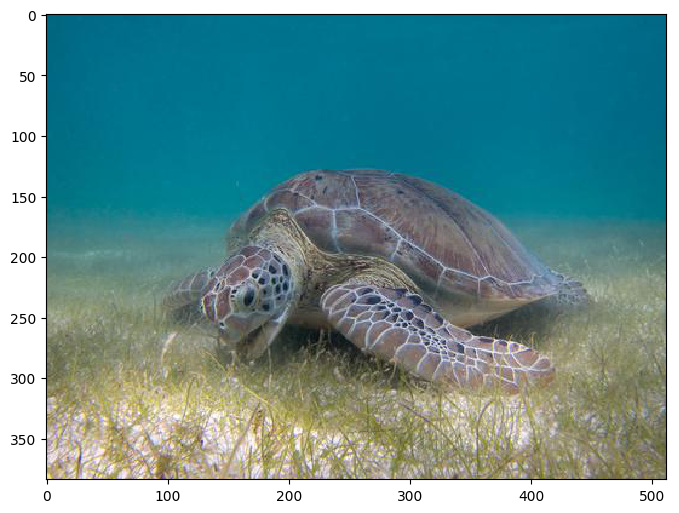

In [3]:
print(content_img.shape)
pt.imshow(content_img[0])

(1, 336, 512, 3)


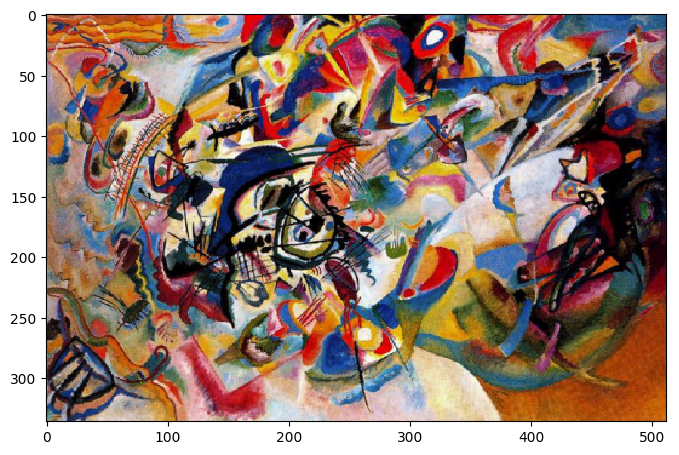

In [4]:
print(style_img.shape)
pt.imshow(style_img[0])

In [0]:
vgg_img_mean_val = np.array([103.939, 116.779, 123.68])

def process_image(img):
    '''
    Input: images with float in [0, 1] for and RGB channel
    Output: images of VGG format (float in [0, 255] and BGR channel)
    '''
    img = img*255
    img = img[:, :, :, ::-1]-vgg_img_mean_val
    return img
  
def deprocess_image(img):
    '''
    Input: images of VGG format (float in [0, 255] and BGR channel)
    Output: images with float in [0, 1] for and RGB channel
    '''
    img = img+vgg_img_mean_val
    img = img[:, :, :, ::-1]/255
    return img

In [0]:
content_img = process_image(content_img)
style_img = process_image(style_img)

In [0]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

n_content_layer = len(content_layers)
n_style_layer = len(style_layers)

In [0]:
class BuildGraph:
    def __init__(self):
        content = tf.constant(content_img, dtype=tf.float32)
        style = tf.constant(style_img, dtype=tf.float32)
        self.target = tf.Variable(content_img, dtype=tf.float32)
        
        self.content_weight = tf.placeholder(tf.float32, [])
        self.style_weight = tf.placeholder(tf.float32, [])
        self.variation_weight = tf.placeholder(tf.float32, [])
        
        self.lr_rate = tf.placeholder(tf.float32, [])
        
        content_features = self.vgg_layers(content_layers, content)
        style_features = self.vgg_layers(style_layers, style)
        target_features = self.vgg_layers(content_layers+style_layers, self.target)
        
        self.content_loss = 0
        for i in range(n_content_layer):
            self.content_loss = self.content_loss+tf.reduce_mean((content_features[i]-target_features[i])**2)
        self.content_loss = self.content_loss*self.content_weight/n_content_layer
        
        self.style_loss = 0
        for i in range(n_style_layer):
            style_gram = self.gram_matrix(style_features[i])
            target_gram = self.gram_matrix(target_features[i+n_content_layer])
            self.style_loss = self.style_loss+tf.reduce_mean((style_gram-target_gram)**2)        
        self.style_loss = self.style_loss*self.style_weight/n_style_layer
        
        var_loss1 = (self.target[:, :-1, :-1, :]-self.target[:, 1:, :-1, :])**2
        var_loss2 = (self.target[:, :-1, :-1, :]-self.target[:, :-1, 1:, :])**2
        self.variation_loss = tf.reduce_mean(tf.pow(var_loss1+var_loss2, 1.25))*self.variation_weight
        
        self.loss = self.content_loss+self.style_loss+self.variation_loss

        self.train_step = tf.train.AdamOptimizer(self.lr_rate, beta1=0.99, beta2=0.999).minimize(self.loss, var_list=[self.target])
        
    def vgg_layers(self, layer_names, img):
        model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=img)
        for layer in model.layers:
            layer.trainable = False
        outputs = [model.get_layer(layer_name).output for layer_name in layer_names]
        return outputs
        
    def gram_matrix(self, x):
        x = tf.reshape(x, [-1, x.shape[-1]])
        n = tf.cast(x.shape[0], tf.float32)
        gram = tf.matmul(x, x, transpose_a=True)/n
        return gram

In [0]:
graph = BuildGraph()

#init_op = tf.initializers.variables([graph.target])

with tf.keras.backend.get_session() as sess:
    K.set_session(sess)
#    sess.run(init_op)
    graph.target.load(content_img, sess)
    
    for i_epoch in range(20):
        _, content_loss, style_loss, variation_loss = \
        sess.run((graph.train_step, graph.content_loss, graph.style_loss, graph.variation_loss),
                  feed_dict={graph.content_weight: 1e3,
                             graph.style_weight: 1e-2,
                             graph.variation_weight: 0,
                             graph.lr_rate: 5})
        print('epoch %d, content_loss = %.6e, style_loss = %.6e, variation_loss = %.6e'%(i_epoch,
                                                                                         content_loss,
                                                                                         style_loss,
                                                                                         variation_loss))
    target_img = sess.run((graph.target))
    target_img = np.clip(deprocess_image(target_img), 0, 1)
    
    pt.imshow(target_img[0])